# Compositional VAE

### IMPORT NECESSARY MODULES

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#!pip install moviepy
#! conda update -y pytorch torchvision -c pytorch
#! pip install pyro-ppl --upgrade
# pip install --upgrade Pillow
#!pip install seaborn
#!pip install leidenalg

In [3]:
import os
import sys
import glob
import numpy as np
import torch

#os.environ['CUDA_LAUNCH_BLOCKING'] = "1" #for debugging, it decrease performance dramatically

# Check versions
from platform import python_version
print("python_version() ---> ",python_version())
print("torch.__version__ --> ",torch.__version__)

python_version() --->  3.7.7
torch.__version__ -->  1.5.0


In [4]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML, Image
from mpl_toolkits.mplot3d import Axes3D

from MODULES.utilities import *
from MODULES.vae_model import *

### We expect to find the file "parameters.json" in the execution directory

In [5]:
params = load_json_as_dict("parameters_MERFISH.json")
#params = load_json_as_dict("parameters_VISIUM.json")
#params = load_json_as_dict("parameters.json")
params

{'wdl.alias': '',
 'wdl.memo': 'merfish data',
 'wdl.file_train': 'gs://ld-data-bucket/Allen_smFISH/preprocessed_smFISH_stitched_OLEH.tif',
 'wdl.file_test': 'gs://ld-results-bucket/ckpt/dummy_1.pkl',
 'wdl.file_ckpt': 'gs://ld-results-bucket/ckpt/dummy_2.pkl',
 'wdl.bucket_output': 'gs://ld-results-bucket',
 'wdl.dir_output': 'merfish_aug_12_v2',
 'wdl.notebook_name': 'MAIN.ipynb',
 'wdl.git_repo': 'https://github.com/spacetx/spacetx-research.git',
 'wdl.commit_or_branch': 'master',
 'simulation': {'__comment': 'there are 3 types of runs: scratch, resume, pretrained',
  'type': 'scratch',
  'MAX_EPOCHS': 5000,
  'TEST_FREQUENCY': 100,
  'CHECKPOINT_FREQUENCY': 100,
  'batch_size': 128},
 'architecture': {'__comment': 'architecture parameters, level_zwhere_output is between 0 and n_max_pool included',
  'dim_zinstance': 20,
  'dim_zwhere': 4,
  'dim_logit': 1,
  'cropped_size': 28,
  'n_max_pool': 4,
  'level_zwhere_and_logit_output': 2,
  'level_background_output': 4,
  'n_ch_output_f

# prepare the file names

In [6]:
# CROMWELL will localize: 
# gs://ld-data-bucket/data/fashionmnist_train.pkl -> execution_dir/ld-data-bucket/data/fashionmnist_train.pkl
# Therefore I just need to remove  "gs://"
# Note that every path is relative to the execution_dir

train_file = os.path.basename(params["wdl.file_train"])
test_file = os.path.basename(params["wdl.file_test"])
ckpt_file = os.path.basename(params["wdl.file_ckpt"])
dir_output = params["wdl.dir_output"]

dir_output = os.path.join("NEW_ARCHIVE", dir_output)
tiling_file = os.path.join(dir_output, "tiling.pt")


# create output directionry if it does nto exists
try:
    os.mkdir(dir_output)
except FileExistsError:
    pass

# Save input_json_file to output dir
json_param_file = os.path.join(dir_output, "parameters.json")
save_dict_as_json(params,json_param_file)

# checks
assert os.path.isfile(train_file)
assert os.path.isfile(test_file)
assert os.path.isfile(ckpt_file)
    
print(train_file)
print(test_file)
print(dir_output)
print(json_param_file)
print(ckpt_file)
print(tiling_file)

preprocessed_smFISH_stitched_OLEH.tif
dummy_1.pkl
NEW_ARCHIVE/merfish_aug_12_v2
NEW_ARCHIVE/merfish_aug_12_v2/parameters.json
dummy_2.pkl
NEW_ARCHIVE/merfish_aug_12_v2/tiling.pt


# DATA

In [7]:
#print("get the data")
#train_file="multi_disk_train_shading_bg_v3.pkl"
#test_file="multi_disk_test_shading_bg_v3.pkl"
#multi_mnist_test_no_bg.pkl

#train_file="multi_mnist_train_simple_v3.pkl"
#test_file="multi_mnist_test_simple_v3.pkl"

##train_file="multi_disk_train_shading_bg.pkl"
##test_file="multi_disk_test_shading_bg.pkl"

#x_train, y_train = load_obj(train_file)
#train_loader = LoaderInMemory(x=x_train, 
#                              y=y_train, 
#                              pin_in_cuda_memory=torch.cuda.is_available(),
#                              batch_size=params["simulation"]["batch_size"],  
#                              shuffle=True)
#                               
#x_test, y_test = load_obj(train_file)
#test_loader = LoaderInMemory(x=x_test, 
#                             y=y_test, 
#                             pin_in_cuda_memory=torch.cuda.is_available(),
#                             batch_size=params["simulation"]["batch_size"],  
#                             shuffle=False)

In [8]:
from MODULES.namedtuple import PreProcess, ImageBbox
preprocessed = torch.load(train_file)
print("FIELDS ->", preprocessed._fields)

my_shape = preprocessed.img.shape
my_dtype = preprocessed.img.dtype
                   
print("DEBUG ->",my_shape, my_dtype)

FIELDS -> ('img', 'roi_mask', 'bbox_original', 'bbox_crop')
DEBUG -> torch.Size([1, 1, 2688, 2482]) torch.float32


### Load preprocessed images and convert to float torch in (0,1)

In [9]:
img_torch = preprocessed.img.float()
roi_mask_torch = preprocessed.roi_mask.bool()
assert len(img_torch.shape) == len(roi_mask_torch.shape) == 4
print(img_torch.shape)
print(roi_mask_torch.shape)

torch.Size([1, 1, 2688, 2482])
torch.Size([1, 1, 2688, 2482])


In [10]:
BATCH_SIZE = params["simulation"]["batch_size"]
SIZE_CROPS = params["input_image"]["size_raw_image"]

N_test = 256
N_train = 128
conditional_crop_test = ConditionalRandomCrop(desired_w=SIZE_CROPS, desired_h=SIZE_CROPS, 
                                              min_roi_fraction=0.9, n_crops_per_image=N_test)

conditional_crop_train = ConditionalRandomCrop(desired_w=SIZE_CROPS, desired_h=SIZE_CROPS, 
                                               min_roi_fraction=0.9, n_crops_per_image=N_train)

test_data = conditional_crop_test.forward(img=img_torch,
                                          roi_mask=roi_mask_torch)

print(test_data.shape)

torch.Size([256, 1, 80, 80])


cuda:0
Dataset lenght: 256
img.shape torch.Size([256, 1, 80, 80])
img.dtype torch.float32
img.device cuda:0
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0., device='cuda:0') tensor(0.8614, device='cuda:0')


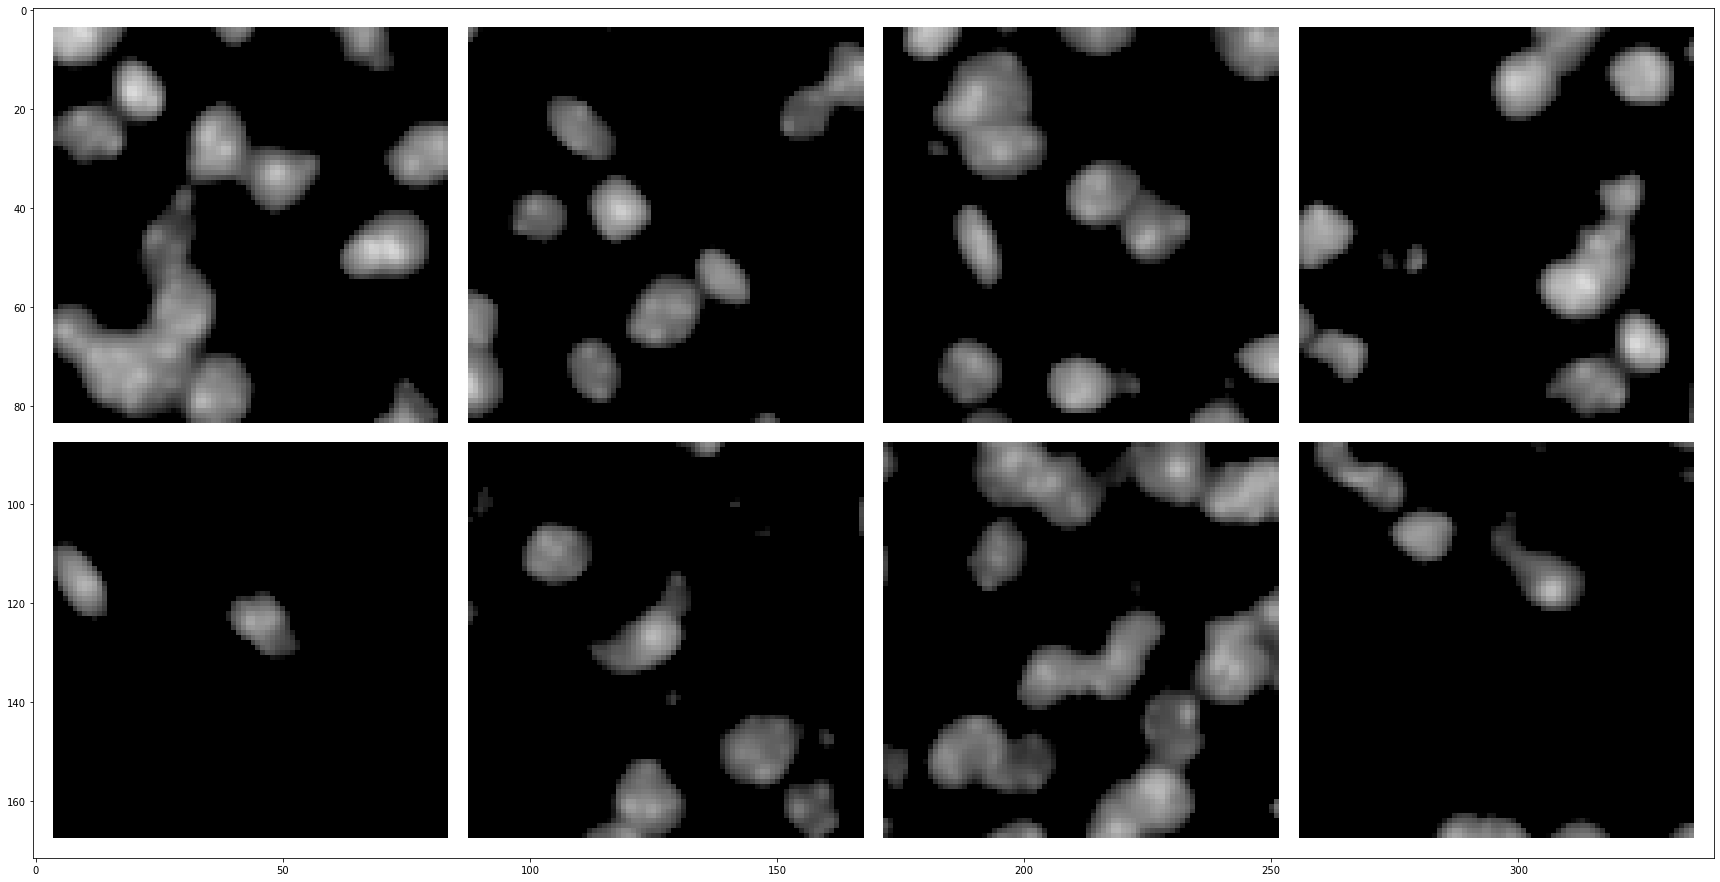

In [11]:
torch.cuda.empty_cache()
test_loader = SpecialDataSet(img=test_data, 
                             data_augmentation=None,
                             device='cuda:0' if torch.cuda.is_available() else 'cpu',
                             shuffle=False,
                             drop_last=False,
                             batch_size=BATCH_SIZE)

print(test_loader.img.device)
test_loader.check_batch()

In [12]:
#for a in iter(test_loader):
#    img,labels,index = a
#    print(img.shape)

In [13]:
torch.cuda.empty_cache()
train_loader = SpecialDataSet(img=img_torch, 
                             roi_mask=roi_mask_torch,
                             data_augmentation=conditional_crop_train,
                             device='cuda:0' if torch.cuda.is_available() else 'cpu',
                             shuffle=True,
                             drop_last=True,
                             batch_size=BATCH_SIZE)

Dataset lenght: 128
img.shape torch.Size([128, 1, 2688, 2482])
img.dtype torch.float32
img.device cuda:0
MINIBATCH: img.shapes labels.shape, index.shape -> torch.Size([8, 1, 80, 80]) torch.Size([8]) torch.Size([8])
MINIBATCH: min and max of minibatch tensor(0., device='cuda:0') tensor(0.8528, device='cuda:0')


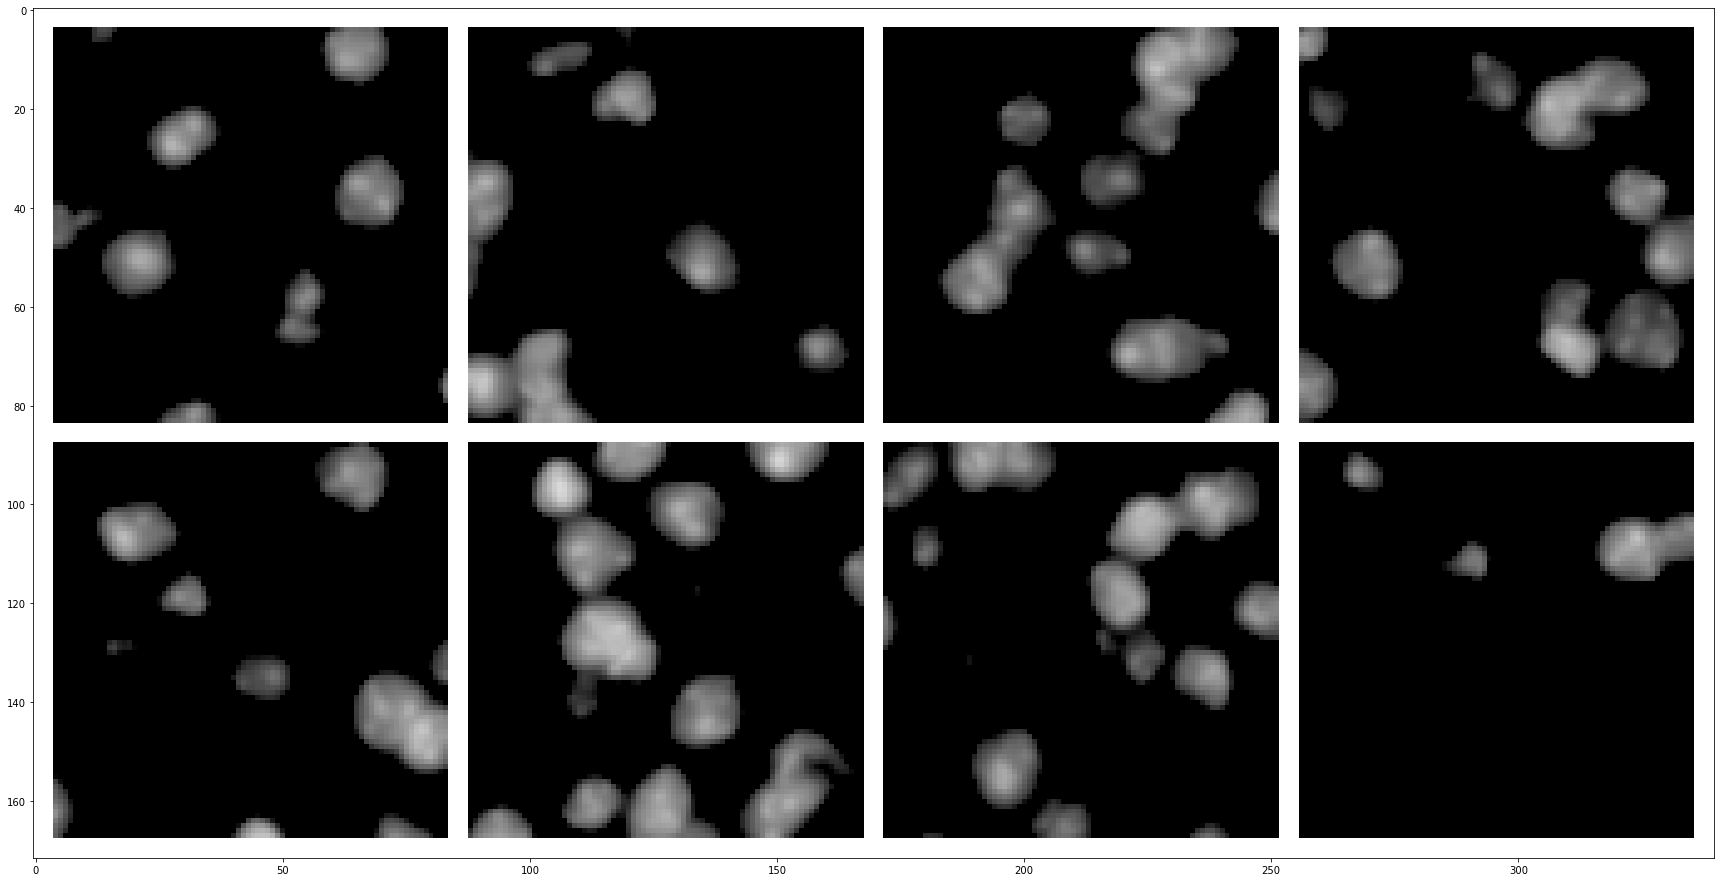

In [14]:
train_loader.check_batch()

# Instantiate model and optimizer

In [15]:
params = load_json_as_dict(json_param_file)
#params

In [16]:
vae = CompositionalVae(params)
optimizer = instantiate_optimizer(model=vae, dict_params_optimizer=params["optimizer"])

### Check the UNET resolution

In [17]:
vae.sigma_fg.device

device(type='cuda', index=0)

imgs_in.shape, imgs_out.shape torch.Size([4, 1, 80, 80]) torch.Size([9, 4, 1, 80, 80])


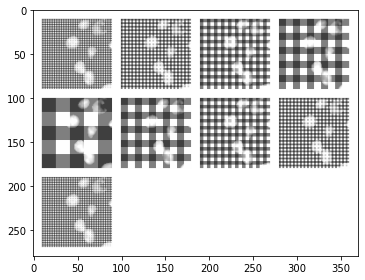

In [18]:
imgs_in, labels, index = test_loader.load(batch_size=4)
imgs_out = vae.inference_and_generator.unet.show_grid(imgs_in)

print("imgs_in.shape, imgs_out.shape", imgs_in.shape, imgs_out.shape)

show_batch(imgs_out[:,0])

### Check the vae architecture

In [19]:
# vae

### Does the untrained generator match the data

torch.Size([8, 3, 80, 80])


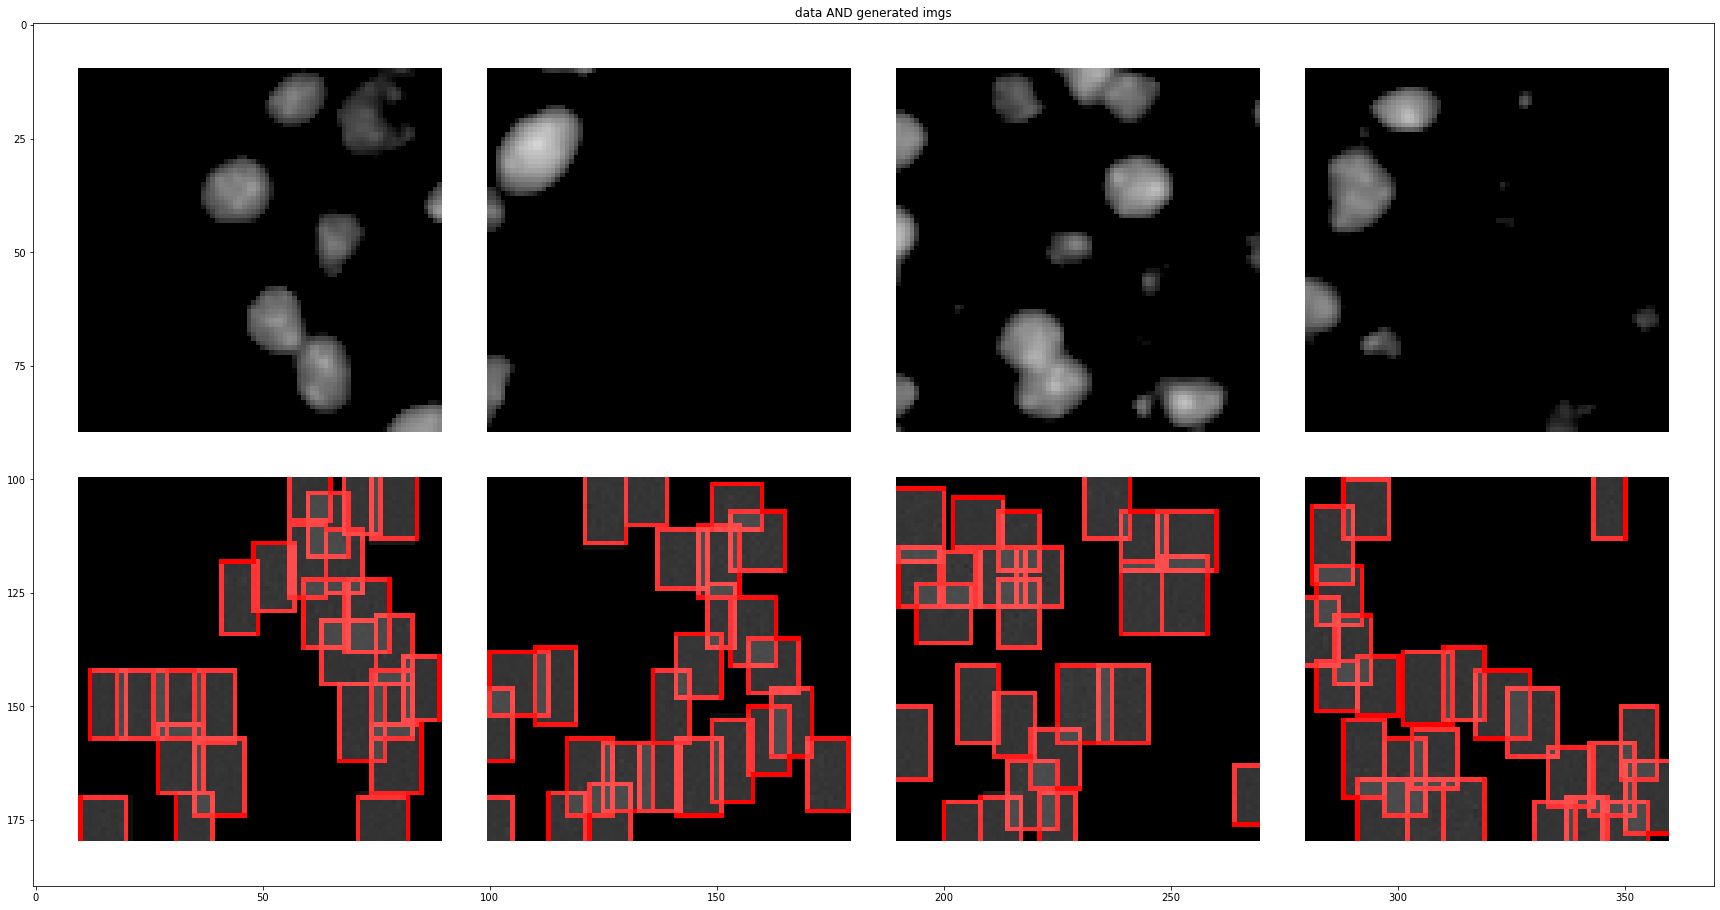

In [20]:
vae.eval()
generated_data = vae.generate(imgs_in=imgs_in, draw_boxes=True, draw_bg=False)
tmp = torch.cat((imgs_in.expand(-1,3,-1,-1),generated_data.imgs[:4].expand(-1,3,-1,-1)), dim=0)
print(tmp.shape)
show_batch(tmp, title="data AND generated imgs", figsize=(24,24))

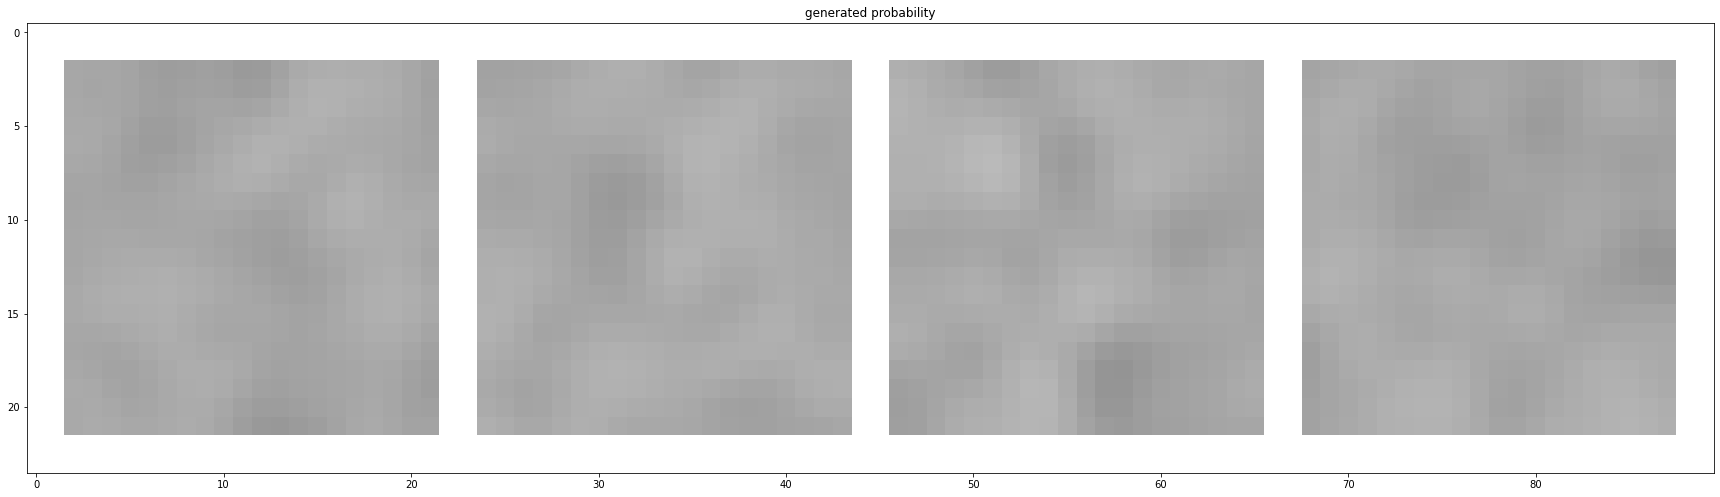

In [21]:
show_batch(generated_data.inference.p_map, n_padding=2, title="generated probability", figsize=(24,24))

# Check the constraints

In [22]:
vae.dict_soft_constraints

{'__comment': 'all the parameters about the soft constraints',
 'overlap': {'__comment': 'cost which discourages masks from overlapping',
  'strength': 0.01,
  'exponent': 1},
 'mask_volume_absolute': {'__comment': 'cost which discourage masks which are too large or too small',
  'lower_bound_value': 40,
  'lower_bound_width': 5,
  'lower_bound_strength': 0,
  'lower_bound_exponent': 2,
  'upper_bound_value': 300,
  'upper_bound_width': 5,
  'upper_bound_strength': 0,
  'upper_bound_exponent': 2}}

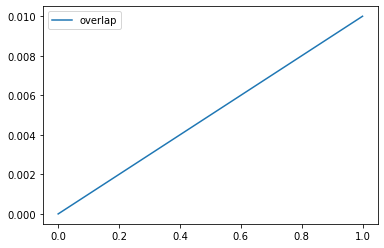

In [23]:
x1=torch.linspace(0,1,100)
y1=sample_from_constraints_dict(dict_soft_constraints=vae.dict_soft_constraints,
                                var_name="overlap", 
                                var_value=x1, 
                                verbose=False)
plt.plot(x1,y1, label="overlap")
plt.legend()

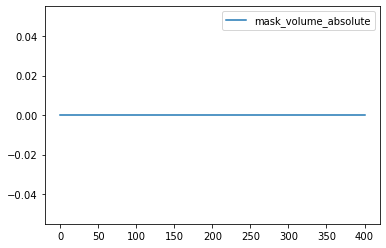

In [24]:
x1=torch.linspace(0,400,100)
y1=sample_from_constraints_dict(dict_soft_constraints=vae.dict_soft_constraints,
                                var_name="mask_volume_absolute", 
                                var_value=x1, 
                                verbose=False)
plt.plot(x1,y1, label="mask_volume_absolute")
plt.legend()

# There are 3 possible simulation types: scratch, resumed, pretrained

In [25]:
print("simulation type = "+str(params["simulation"]["type"]))

    
if (params["simulation"]["type"] == "scratch"):
    
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999

elif (params["simulation"]["type"] == "resume"):
    
    
    resumed = file2resumed(path=ckpt_file, device=None)
    #resumed = file2resumed(path=ckpt_file, device='cpu')
        
    load_model_optimizer(resumed=resumed,  
                         model=vae,
                         optimizer=optimizer,
                         overwrite_member_var=True)
    
    ckp = load_info(resumed=resumed, 
                    load_epoch=True, 
                    load_history=True)
    
    epoch_restart = ckp.epoch
    history_dict = ckp.history_dict
    min_test_loss = min(history_dict["test_loss"])
    
    
elif (params["simulation"]["type"] == "pretrained"):
    
    resumed = file2resumed(path=ckpt_file, device=None)
    # resumed = file2resumed(path=ckpt_file, device='cpu')
        
    load_model_optimizer(resumed=resumed,  
                         model=vae,
                         optimizer=None,
                         overwrite_member_var=False)
       
    epoch_restart = -1
    history_dict = {}
    min_test_loss = 99999999
    
else:
    raise Exception("simulation type is NOT recognized")
    
# instantiate the scheduler if necessary    
if params["optimizer"]["scheduler_is_active"]:
    scheduler = instantiate_scheduler(optimizer=optimizer, dict_params_scheduler=params["optimizer"])

simulation type = scratch


In [26]:
vae.geco_dict = params["GECO_loss"]
print(vae.geco_dict)

{'__comment': 'if active=false use ELBO, else use GECO with Log-Likelihood threshold = n_pixels * n_channel * threshold', 'is_active': True, 'factor_balance_range': [0.1, 0.8, 0.9], 'factor_sparsity_range': [-1, 1.0, 100], 'target_fg_fraction': [0.05, 0.2], 'target_mse': [0.85, 1.0], 'bg_std': 0.05, 'fg_std': 0.05}


# Training loop

In [27]:
TEST_FREQUENCY = params["simulation"]["TEST_FREQUENCY"]
CHECKPOINT_FREQUENCY = params["simulation"]["CHECKPOINT_FREQUENCY"]
NUM_EPOCHS = params["simulation"]["MAX_EPOCHS"]

In [28]:
for delta_epoch in range(1,NUM_EPOCHS+1):
    epoch = delta_epoch+epoch_restart    
    
    vae.prob_corr_factor=linear_interpolation(epoch, 
                                              values=params["shortcut_prob_corr_factor"]["values"],
                                              times=params["shortcut_prob_corr_factor"]["times"])
        
    with torch.autograd.set_detect_anomaly(True):
    #with torch.autograd.set_detect_anomaly(False):
        with torch.enable_grad():
            vae.train()
            train_metrics = process_one_epoch(model=vae, 
                                              dataloader=train_loader, 
                                              optimizer=optimizer, 
                                              verbose=(epoch==0), 
                                              weight_clipper=None)
        with torch.no_grad():        
            s = pretty_print_metrics(epoch, train_metrics, is_train=True)
            print(s,"prob_factor=%.4f" %(vae.prob_corr_factor))
            
            history_dict = append_dict_to_dict(source=train_metrics, 
                                               target=history_dict,
                                               prefix_exclude="wrong_examples",
                                               prefix_to_add="train_")
        
    if params["optimizer"]["scheduler_is_active"]:
        scheduler.step()
    
    if(epoch % TEST_FREQUENCY == 0):
        with torch.no_grad():
            vae.eval()
            test_metrics = process_one_epoch(model=vae, 
                                             dataloader=test_loader, 
                                             optimizer=optimizer, 
                                             verbose=(epoch==0), 
                                             weight_clipper=None)
        
            s = pretty_print_metrics(epoch, test_metrics, is_train=False)
            print(s,"prob_factor %.4f" %(vae.prob_corr_factor))
        
            history_dict = append_dict_to_dict(source=train_metrics, 
                                               target=history_dict,
                                               prefix_exclude="wrong_examples",
                                               prefix_to_add="test_")
        
            test_loss = test_metrics["loss"]
            min_test_loss = min(min_test_loss, test_loss)
            
            if((test_loss == min_test_loss) or ((epoch % CHECKPOINT_FREQUENCY) == 0)): 
                checkpoint_file = os.path.join(dir_output, "ckp_"+str(epoch)+".pkl")
                history_file = os.path.join(dir_output, "history_"+str(epoch)+".pkl")
            
                save_everything(model=vae, 
                                optimizer=optimizer, 
                                history_dict=history_dict, 
                                epoch=epoch, 
                                hyperparams_dict=params, 
                                path=checkpoint_file)
            
                save_dict_as_json(history_dict, path=history_file)
                print("saved files -> "+checkpoint_file+"  "+history_file)

i =   0 train_loss=23.67055
Train [epoch    0] loss=23.671, mse=16.068, reg=0.880, kl_tot=2.743, sparsity=9.563, fg_fraction=0.149, geco_sp=1.000, geco_bal=0.800 prob_factor=0.5000
i =   0 train_loss=23.13159
i =   1 train_loss=23.66794
Test  [epoch    0] loss=23.400, mse=15.803, reg=0.829, kl_tot=2.694, sparsity=9.541, fg_fraction=0.146, geco_sp=1.000, geco_bal=0.801 prob_factor 0.5000
saved files -> NEW_ARCHIVE/merfish_aug_12_v2/ckp_0.pkl  NEW_ARCHIVE/merfish_aug_12_v2/history_0.pkl
Train [epoch    1] loss=22.888, mse=15.154, reg=0.834, kl_tot=2.691, sparsity=9.546, fg_fraction=0.145, geco_sp=1.000, geco_bal=0.801 prob_factor=0.5000
Train [epoch    2] loss=22.819, mse=15.115, reg=0.809, kl_tot=2.674, sparsity=9.519, fg_fraction=0.143, geco_sp=1.000, geco_bal=0.802 prob_factor=0.5000
Train [epoch    3] loss=22.216, mse=14.552, reg=0.758, kl_tot=2.744, sparsity=9.382, fg_fraction=0.137, geco_sp=1.000, geco_bal=0.803 prob_factor=0.5000
Train [epoch    4] loss=39.990, mse=12.793, reg=0.3

KeyboardInterrupt: 

In [ ]:
# train_metrics
# history_dict

# Test generator after training

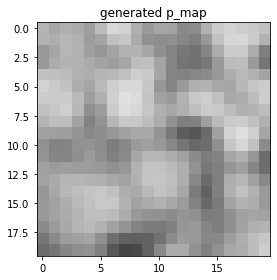

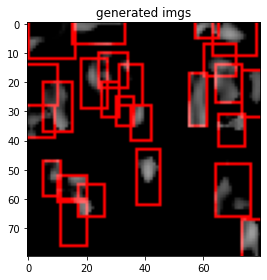

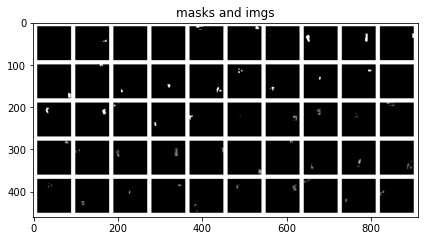

In [29]:
imgs_in_tmp, labels, index = train_loader.load(batch_size=3)
auch = vae.generate(imgs_in=imgs_in_tmp[:1], draw_boxes=True)

pmap_gen = show_batch(auch.inference.p_map[:8], title="generated p_map")
imgs_gen = show_batch(auch.imgs[:8], title="generated imgs")
display(pmap_gen, imgs_gen)

big_mask = auch.inference.big_mask[:,0]
big_img = auch.inference.big_img[:,0]
tmp = torch.cat((big_mask.expand(-1,big_img.shape[-3],-1,-1), big_img),dim=0)
show_batch(tmp, n_col=tmp.shape[0]//5, title="masks and imgs")

# Check segmentation WITHOUT tiling

In [30]:
imgs_in,labels,index = test_loader.load(batch_size=8)
segmentation = vae.segment(imgs_in)
print(segmentation.integer_mask.shape, segmentation.similarity)

torch.Size([8, 1, 80, 80]) None


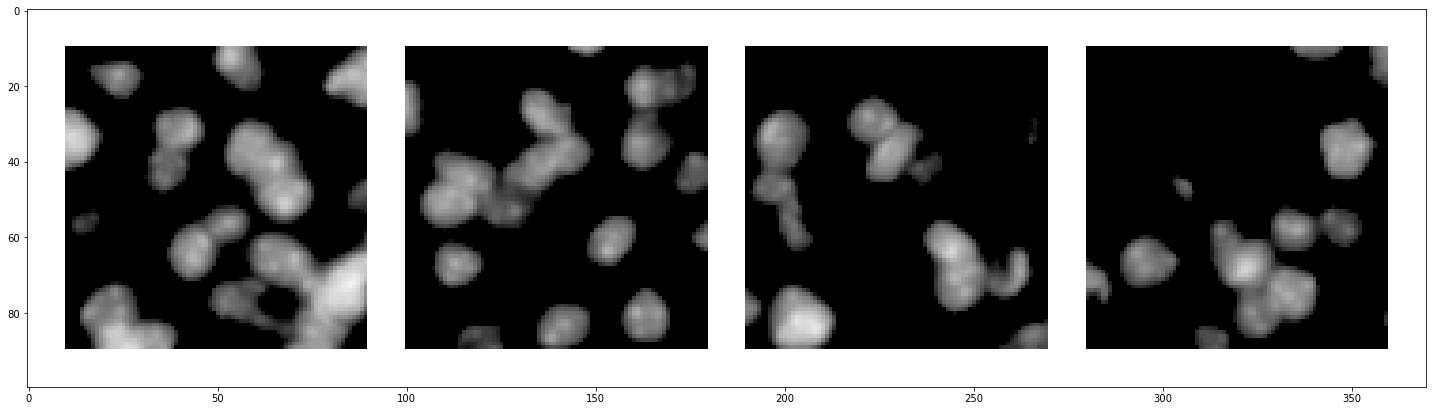

In [31]:
show_batch(segmentation.raw_image[:4], figsize=(20,10))

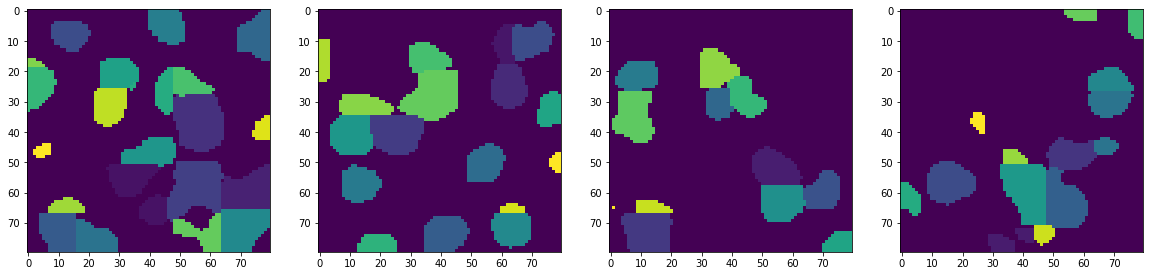

In [32]:
plot_grid(segmentation.integer_mask[:4,0].cpu(), figsize=(20,20))

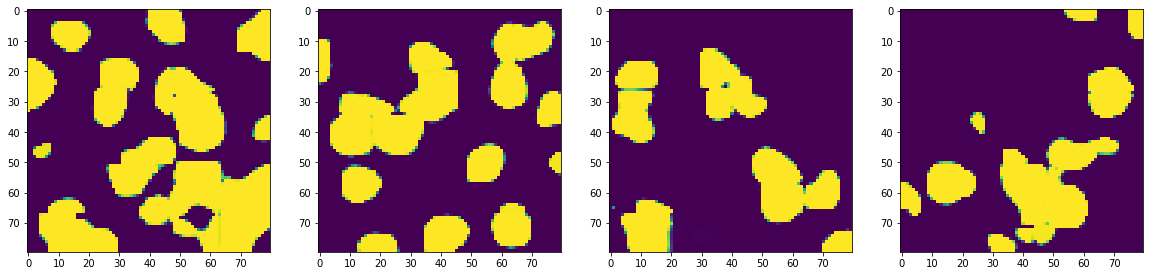

In [33]:
plot_grid(segmentation.fg_prob[:4,0].cpu(), figsize=(20,20))

# Check segmentation WITH tiling

In [34]:
train_loader.cum_roi_mask.shape

torch.Size([128, 1, 2688, 2482])

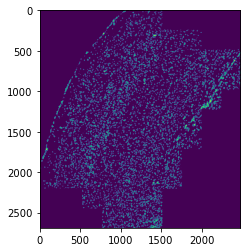

In [35]:
_ = plt.imshow(train_loader.img[0,:,:10000,:10000].cpu().permute(1,2,0).squeeze(-1))

Text(0.5, 1.0, 'roi mask')

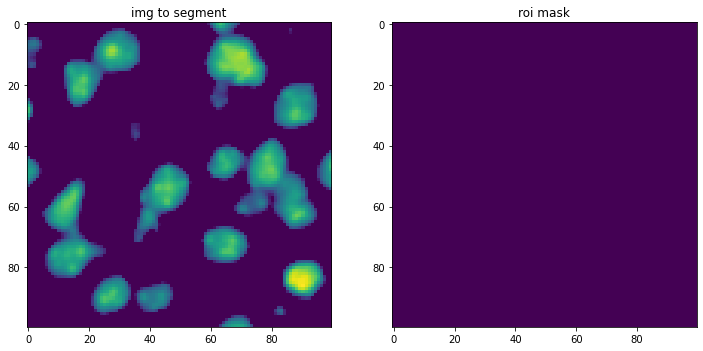

In [36]:
# vae.eval()
#img_to_segment = train_loader.img[0,:,8000:10000,8000:10000]
#cum_roi_mask= train_loader.cum_roi_mask[0, :,8000:10000,8000:10000]

img_to_segment = train_loader.img[0,:,1000:1100,1000:1100]
roi_mask = train_loader.roi_mask[0,:,1000:1100,1000:1100]


fig, axs = plt.subplots(ncols=2, figsize=(12,12))
axs[0].imshow(img_to_segment.permute(1,2,0).squeeze(-1).cpu())
axs[1].imshow(roi_mask.permute(1,2,0).squeeze(-1).cpu())
axs[0].set_title("img to segment")
axs[1].set_title("roi mask")

In [54]:
#img_to_segment = train_loader.img[0] 
#img_to_segment = train_loader.img[0,:,1000:1100,1000:1100]
#img_to_segment = img_to_segment[:,60:,:40]
tiling = vae.segment_with_tiling(single_img=img_to_segment,
                                 roi_mask=roi_mask,
                                 crop_size=None,
                                 stride=(10,10),
                                 n_objects_max_per_patch=None,
                                 prob_corr_factor=None,
                                 overlap_threshold=None,
                                 radius_nn=5,
                                 batch_size=128)

cum_roi_mask.shape -> torch.Size([1, 100, 100])
Each pixel will be segmented 64 times
I am going to process 289 patches
0 out of 2 -> batch_of_imgs.shape = torch.Size([128, 1, 80, 80])
2 out of 2 -> batch_of_imgs.shape = torch.Size([128, 1, 80, 80])


In [55]:
a = torch.bincount(tiling.similarity.index_matrix.view(-1))

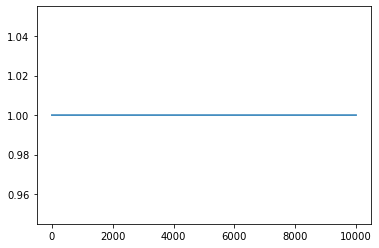

In [56]:
plt.plot(a)

In [66]:
print(tiling.similarity._fields)
print(tiling.similarity.sparse_matrix)


('sparse_matrix', 'index_matrix')
tensor(indices=tensor([[  60,   61,   61,  ..., 9974, 9974, 9974],
                       [  59,   59,   60,  ..., 9971, 9972, 9973]]),
       values=tensor([0.0281, 0.0281, 0.4488,  ..., 0.0300, 0.0300, 0.0300]),
       size=(10000, 10000), nnz=144517, layout=torch.sparse_coo)


In [67]:
print(tiling._fields)
for fld in tiling._fields:
    if isinstance(getattr(tiling, fld),torch.Tensor):
        print(fld, getattr(tiling, fld).shape)
    else:
        print(fld,type(getattr(tiling, fld)))
        
for fld in tiling.similarity._fields:
    if isinstance(getattr(tiling.similarity, fld),torch.Tensor):
        print(fld, getattr(tiling.similarity, fld).shape)
    else:
        print(fld,type(getattr(tiling.similarity, fld)))

('raw_image', 'fg_prob', 'integer_mask', 'bounding_boxes', 'similarity')
raw_image torch.Size([1, 1, 100, 100])
fg_prob torch.Size([1, 1, 100, 100])
integer_mask torch.Size([1, 1, 100, 100])
bounding_boxes <class 'NoneType'>
similarity <class 'MODULES.namedtuple.SparseSimilarity'>
sparse_matrix torch.Size([10000, 10000])
index_matrix torch.Size([100, 100])


In [68]:
# a = tiling.similarity.sparse_matrix.to_dense()
# plt.matshow(a)

In [71]:
#tiling_file = "/Users/ldalessi/DAPI_unsupervised/spacetx-research/TILING_AUG/NEW_tiling_Aug5_radius5.pt" 

#torch.save(tiling, tiling_file)
save_obj(tiling, tiling_file)
print(tiling_file)

NEW_ARCHIVE/merfish_aug_12_v2/tiling.pt


In [72]:
# tiling_original = torch.load(tiling_file)
tiling_original = load_obj(tiling_file)

In [ ]:
figure, axes = plt.subplots(ncols=4, figsize=(12,12))
axes[0].imshow(skimage.color.label2rgb(tiling.integer_mask[0,0].cpu().numpy(),
                                       numpy.zeros_like(tiling.integer_mask[0,0].cpu().numpy()),
                                       alpha=1.0,
                                       bg_label=0))
axes[1].imshow(skimage.color.label2rgb(tiling.integer_mask[0,0].cpu().numpy(),
                                         tiling.raw_image[0,0].cpu().numpy(),
                                         alpha=0.25,
                                         bg_label=0))
axes[2].imshow(tiling.fg_prob[0,0].cpu().numpy(), cmap='gray')
axes[3].imshow(tiling.raw_image[0].cpu().permute(1,2,0).squeeze(-1).numpy(), cmap='gray')

axes[0].set_title("sample integer mask")
axes[1].set_title("sample integer mask")
axes[2].set_title("fg prob")
axes[3].set_title("raw image")


# Check the segmentation results

In [ ]:
#seg_mask = vae.segment_with_tiling(train_loader.x[...,2000:2400,2000:2400], 
#                                   crop_w=80, crop_h=80, 
#                                   stride_w=60, stride_h=60, n_objects_max_per_patch=10)

img_in,labels,index = test_loader.load(batch_size=8)
segmentation = vae.segment(img_in)
print(segmentation._fields)

In [ ]:
vae.eval()
output_test = vae.forward(img_in,
                          draw_image=True,
                          draw_bg=True,
                          draw_boxes=False,
                          verbose=False)

print(img_in.shape, segmentation.integer_mask.shape, output_test.imgs.shape)

In [ ]:
output_test.inference.prob[...,0]

In [ ]:
a = show_batch(img_in, normalize_range=None)
b = show_batch(output_test.imgs, normalize_range=None)
display(a,b)

In [ ]:
chosen=2
figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(img_in[chosen].cpu().permute(1,2,0).squeeze(-1))  # squeeze only works if singleton dimension
axes[1].imshow(skimage.color.label2rgb(skimage.img_as_ubyte(segmentation.integer_mask[chosen,0].cpu()), bg_label=0))
axes[2].imshow(output_test.imgs[chosen].cpu().permute(1,2,0).squeeze(-1)) # squeeze only works if singleton dimension
axes[0].set_title("input image")
axes[1].set_title("segmentation mask")
axes[2].set_title("reconstructed image")

# Check the results

In [ ]:
train_metrics

In [ ]:
for k,v in history_dict.items():
    if k.startswith("train"):
        print(k," -->", history_dict[k][-3:])

In [ ]:
#plt.yscale('log')
y_shift=0
x_shift=0
sign=1
plt.plot(np.arange(x_shift, x_shift+len(history_dict["train_loss"])), 
         sign*np.array(history_dict["train_loss"])+y_shift,'-')
plt.plot(np.arange(x_shift, x_shift+len(history_dict["test_loss"])*TEST_FREQUENCY,TEST_FREQUENCY), 
         sign*np.array(history_dict["test_loss"])+y_shift, '.--')
plt.xlabel('epoch')
plt.ylabel('LOSS = - ELBO')
plt.title('Training procedure')
#plt.ylim(ymax=4, ymin=0)
plt.grid(True)
plt.legend(['train', 'test'])
#plt.show()

fig_file = os.path.join(dir_output, "train.png")
plt.savefig(fig_file)

In [ ]:
plt.plot(np.arange(0,len(history_dict["train_length_GP"])), history_dict["train_length_GP"], '-', label="train")
plt.plot(np.arange(0,len(history_dict["test_length_GP"])*TEST_FREQUENCY,TEST_FREQUENCY), history_dict["test_length_GP"], 'x', label="test")
plt.title('LENGTH GP')
plt.xlabel('epoch')
plt.ylabel('lenght_GP')
plt.legend()
plt.grid(True)

fig_file = os.path.join(dir_output, "lenght_GP.png")
plt.savefig(fig_file)

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('fg fraction av', color=color)
ax1.plot(np.arange(0, len(history_dict["train_fg_fraction"])),
         history_dict["train_fg_fraction"], 'o', color=color, label="train")
ax1.plot(np.arange(0, len(history_dict["test_fg_fraction"])*TEST_FREQUENCY, TEST_FREQUENCY),
         history_dict["test_fg_fraction"], 'x-', color=color, label="test")

ymin=min(params["GECO_loss"]["target_fg_fraction"])
ymax=max(params["GECO_loss"]["target_fg_fraction"])
ax1.plot(ymin*np.ones(len(history_dict["train_fg_fraction"])), '-', color='black', label="y_min")
ax1.plot(ymax*np.ones(len(history_dict["train_fg_fraction"])), '-', color='black', label="y_max")

ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()
#ax1.set_ylim([1000,1870])
plt.legend()
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
ax2.plot(np.arange(0, len(history_dict["train_accuracy"])),
         history_dict["train_accuracy"],'x', color=color)
ax2.plot(np.arange(0, len(history_dict["test_accuracy"])*TEST_FREQUENCY, TEST_FREQUENCY),
         history_dict["test_accuracy"],'-', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.grid()
#ax2.set_ylim([0.97,1.0])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "accuracy.png")
plt.savefig(fig_file)

In [ ]:
f = plt.figure(figsize=(20,20))
ax = f.add_subplot(321)
ax2 = f.add_subplot(322)
ax3 = f.add_subplot(323)
ax4 = f.add_subplot(324)
ax5 = f.add_subplot(325)
ax6 = f.add_subplot(326)
epoch_min, epoch_max = 200, None


loss = np.array(history_dict["train_loss"])
kl_instance = np.array(history_dict["train_kl_instance"])
kl_where = np.array(history_dict["train_kl_where"])
kl_logit = np.array(history_dict["train_kl_logit"])
kl_raw = np.array(history_dict["train_kl_tot"])
mse_raw = np.array(history_dict["train_mse"])
reg_raw = np.array(history_dict["train_reg"])
sparsity_raw = np.array(history_dict["train_sparsity"])
overlap_raw = np.array(history_dict["train_cost_overlap"])
f_geco_sparsity = np.array(history_dict["train_geco_sparsity"])
f_geco_balance = np.array(history_dict["train_geco_balance"])


ax.plot(sparsity_raw,'-',label='sparsity_raw')
ax.plot(overlap_raw,'-',label='cost overlap raw')
ax.set_xlim([epoch_min, epoch_max])
ax.set_ylim([None, 1.01*max(max(sparsity_raw[epoch_min:epoch_max]), max(overlap_raw[epoch_min:epoch_max]))])
ax.grid()
ax.legend()

ax2.plot(kl_instance,'-',label='kl instance raw')
ax2.plot(kl_where,'-',label='kl zwhere raw')
ax2.set_xlim([epoch_min, epoch_max])
ax2.set_ylim([0, 1.01*max(max(kl_instance[epoch_min:epoch_max]),max(kl_where[epoch_min:epoch_max]))])
ax2.grid()
ax2.legend()

ax3.plot(kl_logit,'-',label='kl logit raw')
#ax3.set_ylim([0,1.1])
ax3.set_xlim([epoch_min, epoch_max])
ax3.set_ylim([None, 1.01*max(kl_logit[epoch_min:epoch_max])])
ax3.grid()
ax3.legend()


ax4.plot(f_geco_sparsity ,'x-',label='geco_sparsity')
#ax4.set_ylim([0,100])
ax4.set_xlim([epoch_min, epoch_max])
ax4.set_ylim([None, 1.01*max(f_geco_sparsity[epoch_min:epoch_max])])
ax4.grid()
ax4.legend()

ax5.plot(f_geco_balance ,'x-',label='geco_balance')
ax5.set_xlim([epoch_min, epoch_max])
ax5.set_ylim([None, 1.01*max(f_geco_balance[epoch_min:epoch_max])])
ax5.grid()
ax5.legend()

ax6.plot(loss,'-',label='loss')
ax6.plot(f_geco_sparsity * sparsity_raw,'x-',label='scaled_sparsity')
ax6.plot(f_geco_balance * reg_raw,'x-',label='scaled_reg')
ax6.plot(f_geco_balance * mse_raw,'x-',label='scaled_mse')
ax6.plot((1-f_geco_balance) * kl_raw,'x-',label='scaled_kl')
ax6.set_ylim([0, 1.01*max(loss[epoch_min:epoch_max])])
ax6.set_xlim([epoch_min, epoch_max])
ax6.grid()
ax6.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "metrics.png")
plt.savefig(fig_file)

In [ ]:
params["GECO_loss"]

In [ ]:
fontsize=20
labelsize=20
f = plt.figure(figsize=(20,20))
ax1 = f.add_subplot(311)
ax2 = f.add_subplot(312)
ax3 = f.add_subplot(313)
epoch_min, epoch_max = 0, None


#-----------------------------------

color = 'tab:red'
ax1.set_xlabel('epochs', fontsize=fontsize)
ax1.set_ylabel('fg_fraction', fontsize=fontsize, color=color)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.plot(history_dict["train_fg_fraction"], '.--', color=color, label="n_object")
ax1.set_xlim([epoch_min, epoch_max])
ymin=min(params["GECO_loss"]['target_fg_fraction'])
ymax=max(params["GECO_loss"]['target_fg_fraction'])
ax1.plot(ymin*np.ones(len(history_dict["train_fg_fraction"])), '-', color='black', label="y_min")
ax1.plot(ymax*np.ones(len(history_dict["train_fg_fraction"])), '-', color='black', label="y_max")
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid()

ax1b = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax1b.set_xlabel('epochs', fontsize=fontsize)
ax1b.set_ylabel('geco_sparsity', color=color, fontsize=fontsize)
ax1b.tick_params(axis='both', which='major', labelsize=labelsize)
plt.plot(history_dict["train_geco_sparsity"],'-',label="geco_sparsity",color=color)
ax1b.tick_params(axis='y', labelcolor=color)
ax1b.grid()

##------------------------------------

color = 'tab:red'
ax2.set_xlabel('epochs', fontsize=fontsize)
ax2.set_ylabel('mse av', fontsize=fontsize, color=color)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.plot(history_dict["train_mse"], '.--', color=color, label="mse av")
ax2.set_xlim([epoch_min, epoch_max])

ymin=min(params["GECO_loss"]["target_mse"])
ymax=max(params["GECO_loss"]["target_mse"])
ax2.plot(ymin*np.ones(len(history_dict["train_mse"])), '-', color='black', label="y_min")
ax2.plot(ymax*np.ones(len(history_dict["train_mse"])), '-', color='black', label="y_max")
ax2.tick_params(axis='y', labelcolor=color)

ax2.grid()

ax2b = ax2.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax2b.set_xlabel('epochs', fontsize=fontsize)
ax2b.set_ylabel('geco_balance', fontsize=fontsize, color=color)
plt.plot(history_dict["train_geco_balance"],'-',label="geco_balance",color=color)
ax2b.tick_params(axis='both', which='major', labelsize=labelsize)
ax2b.tick_params(axis='y', labelcolor=color)
ax2b.grid()

##------------------------------------

color = 'tab:red'
ax3.set_xlabel('epochs', fontsize=fontsize)
ax3.set_ylabel('delta_1', fontsize=fontsize, color=color)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.plot(history_dict["train_delta_1"], '.--', color=color, label="delta_1")
ax3.set_xlim([epoch_min, epoch_max])


ax3b = ax3.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:green'
ax3b.set_xlabel('epochs', fontsize=fontsize)
ax3b.set_ylabel('delta_2', fontsize=fontsize, color=color)
plt.plot(history_dict["train_delta_2"],'-',label="delta_2",color=color)
ax3b.tick_params(axis='y', labelcolor=color)
ax3b.tick_params(axis='both', which='major', labelsize=labelsize)
ax3b.grid()

#-----------------------------------

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "geco.png")
plt.savefig(fig_file)

In [ ]:
# Plot of KL vs evidence
fontsize=20
labelsize=20

epoch_min, epoch_max = 200, None
scale= 1
N = len(history_dict["train_mse"][epoch_min:epoch_max])
colors = np.arange(0.0,N,1.0)/N

f = plt.figure(figsize=(20,10))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224, projection='3d')

ax1.set_xlabel('MSE',fontsize=fontsize)
ax1.set_ylabel('KL',fontsize=fontsize)
ax1.tick_params(axis='both', which='major', labelsize=labelsize)
ax1.scatter(history_dict["train_mse"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max],c=colors)
ax1.plot(history_dict["train_mse"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max], '--')
ax1.grid()
#ax1.set_xlim(xmax=2.5)

ax2.set_xlabel('SPARSITY',fontsize=fontsize)
ax2.set_ylabel('MSE',fontsize=fontsize)
ax2.tick_params(axis='both', which='major', labelsize=labelsize)
ax2.scatter(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_mse"][epoch_min:epoch_max], c=colors)
ax2.plot(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_mse"][epoch_min:epoch_max], '--')
ax2.grid()
#ax2.set_xlim(xmax=2.5)

ax3.set_xlabel('SPARSITY',fontsize=fontsize)
ax3.set_ylabel('KL',fontsize=fontsize)
ax3.tick_params(axis='both', which='major', labelsize=labelsize)
ax3.scatter(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max], c=colors)
ax3.plot(history_dict["train_sparsity"][epoch_min:epoch_max], history_dict["train_kl_tot"][epoch_min:epoch_max], '--')
ax3.grid()
#ax3.set_xlim(xmax=2.5)


ax4.scatter(history_dict["train_kl_tot"][epoch_min:epoch_max],
         history_dict["train_sparsity"][epoch_min:epoch_max],
         history_dict["train_mse"][epoch_min:epoch_max], c=colors )

ax4.plot(history_dict["train_kl_tot"][epoch_min:epoch_max],
         history_dict["train_sparsity"][epoch_min:epoch_max],
         history_dict["train_mse"][epoch_min:epoch_max], '--', label='training')
ax4.set_xlabel('kl_tot', fontsize=fontsize)
ax4.set_ylabel('sparsity', fontsize=fontsize)
ax4.set_zlabel('mse', fontsize=fontsize)
ax4.legend(prop={'size':fontsize})

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig_file = os.path.join(dir_output, "mse_vs_kll_vs_sparsity.png")
plt.savefig(fig_file)

# Run one epoch in eval mode

In [ ]:
#epoch=100
#load_model_optimizer(path=os.path.join(dir_output, "ckp_"+str(epoch)+".pkl"), model=vae)

vae.eval()
with torch.no_grad():
    test_metrics = process_one_epoch(model=vae, 
                                     dataloader=test_loader)
    print(test_metrics)

# Check the error

In [ ]:
ref_img_pkl = os.path.join(dir_output, "reference.pkl")
tmp_list = [0, 1, 2,3,4,5,6,7,8,9]
#tmp_list = [255, 148, 291, 310, 2,3,4,5,6,7,8,9,10]
#tmp_list = [425, 411, 61, 194, 91, 384, 339, 54, 336]

reference_imgs, labels, index =test_loader.load(index=torch.tensor(tmp_list[:9]))
save_obj(reference_imgs, ref_img_pkl)

reference_imgs = load_obj(ref_img_pkl)
b = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")

ref_img_png = os.path.join(dir_output, "reference.png")
b.savefig(ref_img_png)
display(b)

In [ ]:
vae.geco_dict

In [ ]:
chosen=0
with torch.no_grad():
    print("")
    print("")
    print("--- eval mode ---")
    vae.eval()
    output_test = vae.forward(reference_imgs[:],
                              draw_image=True,
                              draw_boxes=True,
                              verbose=True)
    
    print("")
    print("")
    print("--- train mode ---")
    vae.train()
    output_train = vae.forward(reference_imgs[:],
                               draw_image=True,
                               draw_boxes=True,
                               verbose=True)

In [ ]:
pmap_train = show_batch(output_train.inference.p_map, n_col=3,n_padding=4,title="Train Prob MAP")
pmap_test = show_batch(output_test.inference.p_map, n_col=3,n_padding=4,title="Test Prob MAP")

counts_train = torch.sum(output_train.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_train = show_batch(output_train.imgs[:],n_col=3,n_padding=4,title="# rec train "+str(counts_train))

counts_test = torch.sum(output_test.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
rec_test = show_batch(output_test.imgs[:],n_col=3,n_padding=4,title="# rec test "+str(counts_test))

background = show_batch(output_train.inference.big_bg,n_col=3,n_padding=4,title="BACKGROUND")
reference = show_batch(reference_imgs[:],n_col=3,n_padding=4,title="REFERENCE")

background.savefig(os.path.join(dir_output, "background.png"))
reference.savefig(os.path.join(dir_output, "reference.png"))
rec_test.savefig(os.path.join(dir_output, "rec_test.png"))
rec_train.savefig(os.path.join(dir_output, "rec_train.png"))
pmap_test.savefig(os.path.join(dir_output, "pmap_test.png"))
pmap_train.savefig(os.path.join(dir_output, "pmap_train.png"))

In [ ]:
display(background, reference)

In [ ]:
print(output_train.inference.p_map.sum(dim=(-1,-2,-3)).cpu())
print(output_test.inference.p_map.sum(dim=(-1,-2,-3)).cpu())

In [ ]:
display(rec_train,reference)
display(rec_test,reference)

In [ ]:
display(pmap_train,reference)
display(pmap_test,reference)

In [ ]:
plt.imshow(output_train.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_train.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

In [ ]:
plt.imshow(output_test.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
print(torch.topk(output_test.inference.p_map[chosen,0].view(-1), k=10, largest=True, sorted=True)[0])

In [ ]:
_ = plt.hist(output_train.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50, label="pmap_train")
_ = plt.hist(output_test.inference.p_map[0,0].view(-1).cpu().numpy(), density=True, bins=50, label="pmap_test")
plt.legend()
plt.savefig(os.path.join(dir_output, "hist_pmap.png"))

# Visualize one chosen image in details

In [ ]:
output = output_train
how_many_to_show=20
counts = torch.sum(output.inference.prob>0.5,dim=0).view(-1).cpu().numpy().tolist()
prob_tmp = np.round(output.inference.prob[:how_many_to_show,chosen].view(-1).cpu().numpy(),decimals=4)*10000
prob_title = (prob_tmp.astype(int)/10000).tolist()
print("counts ->",counts[chosen]," prob ->",prob_title)

In [ ]:
tmp1 = reference_imgs[chosen]
ch_out = tmp1.shape[-3]
tmp2 = torch.sum(output.inference.big_img[:how_many_to_show,chosen],dim=0).expand(ch_out,-1,-1)
tmp3 = torch.sum(output.inference.big_mask[:how_many_to_show,chosen],dim=0).expand(ch_out,-1,-1)
mask_times_imgs = output.inference.big_mask * output.inference.big_img
tmp4 = torch.sum(mask_times_imgs[:how_many_to_show,chosen],dim=0).expand(ch_out,-1,-1)
print("sum big_masks", torch.max(tmp3))
print("sum big_masks * big_imgs", torch.max(tmp4))
combined = torch.stack((tmp1,tmp2,tmp3,tmp4),dim=0)
print(combined.shape)
b = show_batch(combined, n_col=2, title="# ref, IMGS, MASKS, IMGS*MASKS", figsize=(24,24))
b.savefig(os.path.join(dir_output, "ref_img_mask.png"))
display(b)

In [ ]:
print(torch.min(output.inference.big_mask[:how_many_to_show,chosen]), torch.max(output.inference.big_mask[:how_many_to_show,chosen]))
show_batch(output.inference.big_mask[:how_many_to_show,chosen], n_col=4, title="# MASKS", figsize=(24,24))

In [ ]:
b = show_batch(reference_imgs[chosen]+output.inference.big_mask[:how_many_to_show,chosen], 
               n_col=3, n_padding=4,title="# MASKS over REF, p="+str(prob_title), figsize=(24,24))
b.savefig(os.path.join(dir_output, "mask_over_ref.png"))
display(b)

In [ ]:
b = show_batch(reference_imgs[chosen]+10*output.inference.big_img[:how_many_to_show,chosen], 
               n_col=4, n_padding=4,title="# IMGS over REF, p="+str(prob_title), figsize=(24,24), normalize_range=(0,1))
b.savefig(os.path.join(dir_output, "imgs_over_ref.png"))
display(b)

In [ ]:
output.inference.prob.shape

In [ ]:
prob =  output.inference.prob[:,chosen, None, None, None]

b_img = output.inference.big_img[:,chosen]
ch_out = b_img.shape[-3]
b_mask = output.inference.big_mask[:,chosen].expand(-1,ch_out,-1,-1)
b_combined = b_img * b_mask * prob
tmp = torch.cat((b_mask, b_img, b_combined), dim=0)
b = show_batch(tmp, n_col=tmp.shape[0]//3, n_padding=4, title="# mask, imgs, product. p="+str(prob_title), figsize=(24,24))
b.savefig(os.path.join(dir_output, "mask_imgs_product.png"))
display(b)

### Show the probability map

In [ ]:
_ = plt.imshow(output.inference.p_map[chosen,0].cpu().numpy())
_ = plt.colorbar()
plt.savefig(os.path.join(dir_output, "pmap_chosen.png"))

# MAKE MOVIE

### Test

In [ ]:
epoch="xxx"
a = show_batch(reference_imgs[:9],n_col=3,n_padding=4,title="REFERENCE")
b = show_batch(output.inference.p_map[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
c = show_batch(output.inference.big_bg[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))
d = show_batch(output.imgs[:9],n_col=3,n_padding=4,title="EPOCH = "+str(epoch))

display(a,b,c,d)

# actual loop

In [ ]:
#dir_output = '/home/jupyter/REPOS/spacetx-research/NEW_ARCHIVE/merfish_aug_5_v1'

In [ ]:
for epoch in range(0,5000,5):
    if(epoch<10):
        label ="0000"+str(epoch)
    elif(epoch<100):
        label = "000"+str(epoch)
    elif(epoch<1000):
        label = "00"+str(epoch)
    elif(epoch<10000):
        label = "0"+str(epoch)
    elif(epoch<100000):
        label = str(epoch)
    else:
        raise Exception
    
    try:
        
        ckpt_file = os.path.join(dir_output, "ckp_"+str(epoch)+".pkl")
        resumed = file2resumed(path=ckpt_file, device=None)
        load_model_optimizer(resumed=resumed, 
                             model=vae,
                             optimizer=None,
                             overwrite_member_var=True)
        
        print("epoch, label, prob_cor_factor ->",epoch,label,vae.prob_corr_factor)
        vae.train()
        with torch.no_grad():
            output = vae.forward(reference_imgs,
                                 draw_image=True,
                                 draw_boxes=True,
                                 verbose=False)
        
        b=show_batch(output.imgs[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        b.savefig(os.path.join(dir_output, 'movie_rec_'+label+'.png'), bbox_inches='tight')
        
        b=show_batch(output.inference.p_map[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch), normalize_range=None)
        b.savefig(os.path.join(dir_output, 'movie_map_'+label+'.png'), bbox_inches='tight') 
        
        b=show_batch(output.inference.big_bg[:8],n_col=4,n_padding=4,title="EPOCH = "+str(epoch))
        b.savefig(os.path.join(dir_output, 'movie_bg_'+label+'.png'), bbox_inches='tight') 
        

    except:
        pass

## Make sorted list of image files so that I can create the movie

In [ ]:
dir_output

In [ ]:
rec_filenames = glob.glob(dir_output+"/movie_rec*.png")
map_filenames = glob.glob(dir_output+"/movie_map*.png")
bg_filenames = glob.glob(dir_output+"/movie_bg*.png")

rec_filenames.sort()
map_filenames.sort()
bg_filenames.sort()
print(rec_filenames)
print(map_filenames)
print(bg_filenames)

In [ ]:
def show_frame_rec(n):
    return Image(filename=rec_filenames[n])

def show_frame_map(n):
    return Image(filename=map_filenames[n])

def show_frame_bg(n):
    return display.Image(filename=bg_filenames[n])

def show_frame_all(n):
    try:
        a = Image(filename=bg_filenames[n])
        b = Image(filename=map_filenames[n])
        c = Image(filename=rec_filenames[n])
        return display(a,b,c)
    except IndexError:
        print("list index out of range")
        pass

In [ ]:
# make a gif file
import moviepy.editor as mpy

movie_rec = os.path.join(dir_output, "movie_rec.gif")
movie_map = os.path.join(dir_output, "movie_map.gif")
movie_bg = os.path.join(dir_output, "movie_bg.gif")

frame_per_second = 2
im = mpy.ImageSequenceClip(rec_filenames, fps=frame_per_second)
im.write_gif(movie_rec, fps=frame_per_second)

im = mpy.ImageSequenceClip(map_filenames, fps=frame_per_second)
im.write_gif(movie_map, fps=frame_per_second)

im = mpy.ImageSequenceClip(bg_filenames, fps=frame_per_second)
im.write_gif(movie_bg, fps=frame_per_second)

### Show the movies

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
HTML("<img src="+movie_rec+"></img>")

In [ ]:
HTML("<img src="+movie_map+"></img>")

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
HTML("<img src="+movie_bg+"></img>")

### Look at few frames

In [ ]:
show_frame_all(0)

In [ ]:
show_frame_all(1)

In [ ]:
show_frame_all(2)

In [ ]:
show_frame_all(3)

In [ ]:
show_frame_all(4)

In [ ]:
show_frame_all(5)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

In [ ]:
show_frame_all(10)

In [ ]:
show_frame_all(11)

In [ ]:
show_frame_all(15)

In [ ]:
show_frame_all(20)

In [ ]:
show_frame_all(21)

In [ ]:
show_frame_all(22)

In [ ]:
show_frame_all(23)

In [ ]:
show_frame_all(24)

In [ ]:
show_batch(reference_imgs[:8],n_col=4,n_padding=4,title="REFERENCE")

# FINAL CHECK 1

In [ ]:
imgs_in_tmp, labels, index = train_loader.load(batch_size=8)
auch = vae.generate(imgs_in=imgs_in_tmp[:1], draw_boxes=False)

pmap_gen = show_batch(auch.inference.p_map[:8], title="generated p_map")
imgs_gen = show_batch(auch.imgs[:8], title="generated imgs")
display(pmap_gen, imgs_gen)

In [ ]:
big_mask = auch.inference.big_mask[:,0]
big_img = auch.inference.big_img[:,0]
tmp = torch.cat((big_mask, big_img),dim=0)
print(auch.inference.prob)
show_batch(tmp, n_col=tmp.shape[0]//2, title="masks and imgs", figsize=(24,24))

In [ ]:
print(auch.inference.big_mask.shape)
fg_mask = torch.sum(auch.inference.big_mask, dim=0)
img = torch.sum(auch.inference.big_img, dim=0)
print(fg_mask.shape)

figure, axes = plt.subplots(ncols=3, figsize=(24, 24))
axes[0].imshow(fg_mask[0,0].cpu(), cmap='gray')
axes[1].imshow(img[0,0].cpu(), cmap='gray')
axes[2].imshow((fg_mask[0,0]*img[0,0]).cpu(), cmap='gray')